In [1]:
%load_ext autoreload
%autoreload 2

In [75]:

import numpy
import time
import random

from pysted import base, utils, raster, bleach_funcs
from matplotlib import pyplot
from tqdm.auto import trange

numpy.random.seed(42)
random.seed(42)

# molecules_disposition = (numpy.random.rand(40, 40) > 0.9).astype(int) * 10
delta = 2
molecules_disposition = numpy.zeros((50, 50))
molecules_disposition[
    molecules_disposition.shape[0]//2 - delta : molecules_disposition.shape[0]//2+delta,
    molecules_disposition.shape[1]//2 - delta : molecules_disposition.shape[1]//2+delta] = 10

# Microscope stuff
egfp = {"lambda_": 535e-9,
        "qy": 0.6,
        "sigma_abs": {488: 1.15e-20,
                      575: 6e-21},
        "sigma_ste": {560: 1.2e-20,
                      575: 6.0e-21,
                      580: 5.0e-21},
        "sigma_tri": 1e-21,
        "tau": 3e-09,
        "tau_vib": 1.0e-12,
        "tau_tri": 5e-6,
        "phy_react": {488: 1e-7,   # 1e-4
                      575: 1e-11},   # 1e-8
        "k_isc": 0.26e6}
pixelsize = 10e-9
bleach = False
p_ex = 1e-6
p_ex_array = numpy.ones(molecules_disposition.shape) * p_ex
p_sted = 30e-3
p_sted_array = numpy.ones(molecules_disposition.shape) * p_sted
pdt = 100e-6
pdt_array = numpy.ones(molecules_disposition.shape) * pdt
roi = 'max'


# Generating objects necessary for acquisition simulation
laser_ex = base.GaussianBeam(488e-9)
laser_sted = base.DonutBeam(575e-9, zero_residual=0)
detector = base.Detector(noise=True, background=0)
objective = base.Objective()
fluo = base.Fluorescence(**egfp)

In [76]:
class DyMINMicroscope(base.Microscope):
    def __init__(self, *args, **kwargs):
        super(DyMINMicroscope, self).__init__(*args, **kwargs)
        
def get_signal_dymin(self, datamap, pixelsize, pdt, p_ex, p_sted, indices=None, acquired_intensity=None,
                              pixel_list=None, bleach=True, update=True, seed=None, filter_bypass=False,
                              bleach_func=bleach_funcs.default_bleach):

    datamap_roi = datamap.whole_datamap[datamap.roi]
    pdt = utils.float_to_array_verifier(pdt, datamap_roi.shape)
    p_ex = utils.float_to_array_verifier(p_ex, datamap_roi.shape)
    p_sted = utils.float_to_array_verifier(p_sted, datamap_roi.shape)

    datamap_pixelsize = datamap.pixelsize
    i_ex, i_sted, psf_det = self.cache(datamap_pixelsize)
    if datamap.roi is None:
        # demander au dude de setter une roi
        datamap.set_roi(i_ex)

    datamap_roi = datamap.whole_datamap[datamap.roi]
    pixel_list = utils.pixel_list_filter(datamap_roi, pixel_list, pixelsize, datamap_pixelsize)

    ratio = utils.pxsize_ratio(pixelsize, datamap_pixelsize)
    rows_pad, cols_pad = datamap.roi_corners['tl'][0], datamap.roi_corners['tl'][1]
    laser_pad = i_ex.shape[0] // 2

    prob_ex = numpy.ones(datamap.whole_datamap.shape)
    prob_sted = numpy.ones(datamap.whole_datamap.shape)
    bleached_datamap = numpy.copy(datamap.whole_datamap)
    returned_photons = numpy.zeros(datamap.whole_datamap[datamap.roi].shape)
    scaled_power = numpy.zeros(datamap.whole_datamap[datamap.roi].shape)

    bleached_sub_datamaps_dict = {}
    if isinstance(indices, type(None)):
        indices = 0   # VÉRIF À QUOI INDICES SERT?
    for key in datamap.sub_datamaps_dict:
        bleached_sub_datamaps_dict[key] = numpy.copy(datamap.sub_datamaps_dict[key])
    
    for (row, col) in pixel_list:
        row_slice = slice(row + rows_pad - laser_pad, row + rows_pad + laser_pad + 1)
        col_slice = slice(col + cols_pad - laser_pad, col + cols_pad + laser_pad + 1)

        for scale_power, decision_time in zip([0., 0.25, 1.], [10e-6, 10e-6, pdt[row, col]]):
        
            effective = self.get_effective(datamap_pixelsize, p_ex[row, col], scale_power * p_sted[row, col])
            h, w = effective.shape
            pixel_intensity = numpy.sum(effective * datamap.whole_datamap[row_slice, col_slice])
            pixel_photons = self.detector.get_signal(self.fluo.get_photons(pixel_intensity), decision_time)
            
            if bleach:
                bleach_func(self, i_ex, i_sted, p_ex[row, col], scale_power * p_sted[row, col], 
                            decision_time, bleached_sub_datamaps_dict, 
                            row, col, h, w, prob_ex, prob_sted)
            
            # If no signal is acquired then skip pixel
            scaled_power[row, col] = scale_power
            if pixel_photons < 1:
                break
            
            # Update the photon counts only on the last pixel power scale
            if scale_power == 1.:
                returned_photons[row, col] += pixel_photons

    if update and bleach:
        datamap.sub_datamaps_dict = bleached_sub_datamaps_dict
        datamap.base_datamap = datamap.sub_datamaps_dict["base"]
        datamap.whole_datamap = numpy.copy(datamap.base_datamap)
        
    return returned_photons, bleached_sub_datamaps_dict, scaled_power   
    
print("Creating microscope")
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo)
i_ex, _, _ = microscope.cache(datamap.pixelsize)
datamap.set_roi(i_ex, roi)
print("Done creating microscope")

Creating microscope
Done creating microscope


In [77]:
%matplotlib notebook 

def get_signal_dymin(self, datamap, pixelsize, pdt, p_ex, p_sted, indices=None, acquired_intensity=None,
                              pixel_list=None, bleach=True, update=True, seed=None, filter_bypass=False,
                              bleach_func=bleach_funcs.default_bleach):

    datamap_roi = datamap.whole_datamap[datamap.roi]
    pdt = utils.float_to_array_verifier(pdt, datamap_roi.shape)
    p_ex = utils.float_to_array_verifier(p_ex, datamap_roi.shape)
    p_sted = utils.float_to_array_verifier(p_sted, datamap_roi.shape)

    datamap_pixelsize = datamap.pixelsize
    i_ex, i_sted, psf_det = self.cache(datamap_pixelsize)
    if datamap.roi is None:
        # demander au dude de setter une roi
        datamap.set_roi(i_ex)

    datamap_roi = datamap.whole_datamap[datamap.roi]
    pixel_list = utils.pixel_list_filter(datamap_roi, pixel_list, pixelsize, datamap_pixelsize)

    ratio = utils.pxsize_ratio(pixelsize, datamap_pixelsize)
    rows_pad, cols_pad = datamap.roi_corners['tl'][0], datamap.roi_corners['tl'][1]
    laser_pad = i_ex.shape[0] // 2

    prob_ex = numpy.ones(datamap.whole_datamap.shape)
    prob_sted = numpy.ones(datamap.whole_datamap.shape)
    bleached_datamap = numpy.copy(datamap.whole_datamap)
    returned_photons = numpy.zeros(datamap.whole_datamap[datamap.roi].shape)
    scaled_power = numpy.zeros(datamap.whole_datamap[datamap.roi].shape)

    bleached_sub_datamaps_dict = {}
    if isinstance(indices, type(None)):
        indices = 0   # VÉRIF À QUOI INDICES SERT?
    for key in datamap.sub_datamaps_dict:
        bleached_sub_datamaps_dict[key] = numpy.copy(datamap.sub_datamaps_dict[key])
    
    for (row, col) in pixel_list:
        row_slice = slice(row + rows_pad - laser_pad, row + rows_pad + laser_pad + 1)
        col_slice = slice(col + cols_pad - laser_pad, col + cols_pad + laser_pad + 1)

        for scale_power, decision_time in zip([0., 0.25, 1.], [10e-6, 10e-6, pdt[row, col]]):
        
            effective = self.get_effective(datamap_pixelsize, p_ex[row, col], scale_power * p_sted[row, col])
            h, w = effective.shape
            pixel_intensity = numpy.sum(effective * datamap.whole_datamap[row_slice, col_slice])
            pixel_photons = self.detector.get_signal(self.fluo.get_photons(pixel_intensity), decision_time)
            
            if bleach:
                bleach_func(self, i_ex, i_sted, p_ex[row, col], scale_power * p_sted[row, col], 
                            decision_time, bleached_sub_datamaps_dict, 
                            row, col, h, w, prob_ex, prob_sted)
            
            # If no signal is acquired then skip pixel
            scaled_power[row, col] = scale_power
            if pixel_photons < 1:
                break
            
            # Update the photon counts only on the last pixel power scale
            if scale_power == 1.:
                returned_photons[row, col] += pixel_photons

    if update and bleach:
        datamap.sub_datamaps_dict = bleached_sub_datamaps_dict
        datamap.base_datamap = datamap.sub_datamaps_dict["base"]
        datamap.whole_datamap = numpy.copy(datamap.base_datamap)
        
    return returned_photons, bleached_sub_datamaps_dict, scaled_power

# Replaces get_signal_dymin without recreating the class
microscope.get_signal_dymin = get_signal_dymin.__get__(microscope, DyMINMicroscope)
datamap = base.Datamap(molecules_disposition, pixelsize)
datamap.set_roi(i_ex, roi)

dymin_history = numpy.zeros((10, *bleached["base"][datamap.roi].shape))
for i in trange(dymin_history.shape[0]):
#     fig, axes = pyplot.subplots(1, 4, figsize=(10, 3))
    
#     # Input datamap
#     axes[0].imshow(datamap.whole_datamap[datamap.roi])
#     axes[0].set_title(f"Datamap roi")

    dymin_history[i] = datamap.whole_datamap[datamap.roi]

#     time_start = time.time()
    acquisition, bleached, scaled_power = microscope.get_signal_dymin(datamap, datamap.pixelsize, pdt, p_ex, p_sted,
                                                                        bleach=True, update=True)
#     print(f"ran in {time.time() - time_start} s")
    
#     axes[1].imshow(bleached["base"][datamap.roi])
#     axes[1].set_title(f"Bleached datamap")

#     axes[2].imshow(acquisition)
#     axes[2].set_title(f"Acquired signal (photons)")

#     axes[3].imshow(scaled_power)
#     axes[3].set_title(f"Scale powers")

#     pyplot.show()

datamap = base.Datamap(molecules_disposition, pixelsize)
datamap.set_roi(i_ex, roi)
history = numpy.zeros((10, *bleached["base"][datamap.roi].shape))
for i in trange(history.shape[0]):
    history[i] = datamap.whole_datamap[datamap.roi]
    acquisition, bleached, intensity = microscope.get_signal_and_bleach(datamap, datamap.pixelsize, pdt, p_ex, p_sted,
                                                                        bleach=True, update=True)

<IPython.core.display.Javascript object>


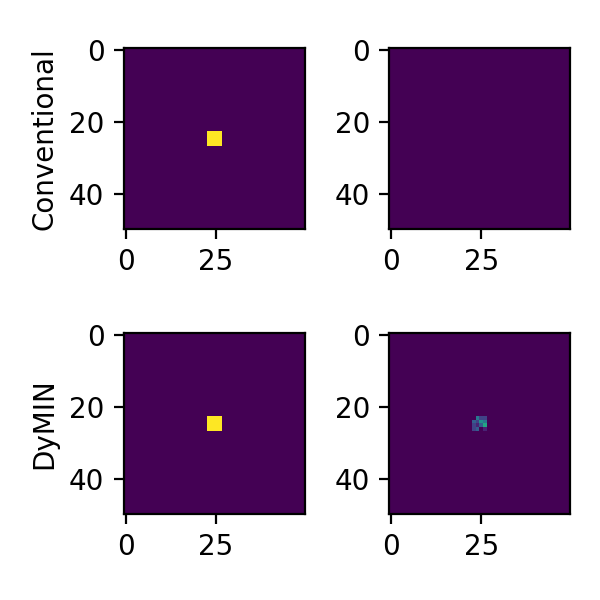

<IPython.core.display.Javascript object>


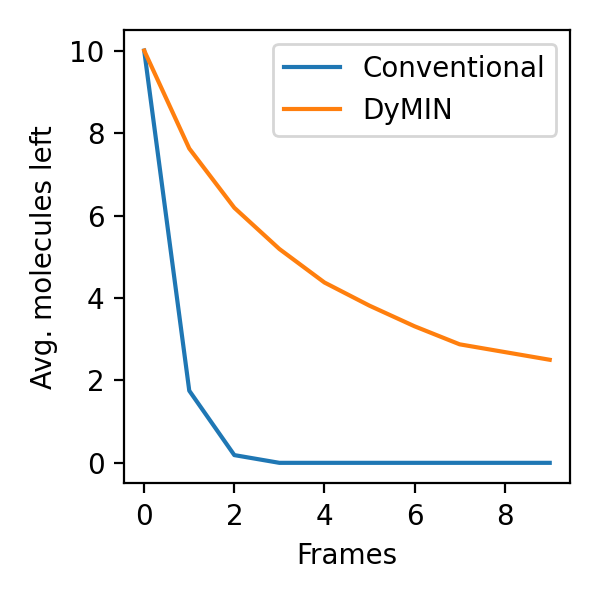

In [81]:
fig, axes = pyplot.subplots(2, 2, figsize=(3, 3), tight_layout=True)
axes[0, 0].imshow(history[0], vmin=0, vmax=10)
axes[0, 1].imshow(history[-1], vmin=0, vmax=10)
axes[1, 0].imshow(dymin_history[0], vmin=0, vmax=10)
axes[1, 1].imshow(dymin_history[-1], vmin=0, vmax=10)
axes[0, 0].set(
    ylabel="Conventional"
)
axes[1, 0].set(
    ylabel="DyMIN"
)

fig, ax = pyplot.subplots(figsize=(3, 3), tight_layout=True)
for hist in (history, dymin_history):
    molecules = hist[:, molecules_disposition.shape[0]//2 - delta : molecules_disposition.shape[0]//2+delta,
                        molecules_disposition.shape[1]//2 - delta : molecules_disposition.shape[1]//2+delta].mean(axis=(-2, -1))
    ax.plot(molecules)
ax.set(
    ylabel="Avg. molecules left", xlabel="Frames"
)
ax.legend(labels=["Conventional", "DyMIN"])
pyplot.show()